In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, Input
import matplotlib.pyplot as plt

In [2]:
address = r"EMG Dataset\\Data\\"

learning_rate = 1e-4
batch_size = 500
patience = 4
window_size = 20
features = 4

window_stride = 10
train_portion = 0.8
val_portion = 0.9

In [3]:
def normalize_fixed(x, current_range, normed_range):
    current_min, current_max = current_range
    normed_min, normed_max = normed_range
    x_normed = (x - current_min) / (current_max - current_min)
    x_normed = x_normed * (normed_max - normed_min) + normed_min
    return x_normed

def openCSV(addr):
    df = pd.read_csv(addr, sep=',', header=None)
    header = df.iloc[0]
    df = pd.DataFrame(df[1:], dtype=float)
    df.columns = header
    return df

In [4]:
try:
    with open('Objects\\data', 'rb') as f:
        data = pickle.load(f)
    print("Loaded saved objects")
        
except:
    data = []
    for person in list(set([i for i in range(1, 16)]) - set([5, 6, 7])):
        print(person)
        for v in range(1, 8):
                for trial in range(1, 4):
                    for r in range(1, 3):
                        tmp1 = []
                        df = pd.read_csv(address + f"subject2_v{v}_rl{r}_trial{trial}_emg.csv")
                        tmp1.append(df['St1_VL'])
                        tmp1.append(df['St1_BF'])
                        tmp1.append(df['St1_TA'])
                        tmp1.append(df['St1_GAL'])
                        df = pd.read_csv(address + f"subject2_v{v}_rl{r}_trial{trial}_trq.csv")
                        tmp1.append(df['St1_Hip_Y'])
                        data.append(tmp1)

    with open("Objects\\data", 'ab') as f:
        pickle.dump(data, f)

Loaded saved objects


In [5]:
dic = {'VL': [1e10, -1e10], 'BF': [1e10, -1e10], 'Hip': [1e10, -1e10], 'TA': [1e10, -1e10], 'GAL': [1e10, -1e10]}

for d in data:
    if max(d[0]) > dic['VL'][1]:
        dic['VL'][1] = max(d[0])
    if min(d[0]) < dic['VL'][0]:
        dic['VL'][0] = min(d[0])

    if max(d[1]) > dic['BF'][1]:
        dic['BF'][1] = max(d[1])
    if min(d[1]) < dic['BF'][0]:
        dic['BF'][0] = min(d[1])

    if max(d[2]) > dic['TA'][1]:
        dic['TA'][1] = max(d[2])
    if min(d[2]) < dic['TA'][0]:
        dic['TA'][0] = min(d[2])

    if max(d[3]) > dic['GAL'][1]:
        dic['GAL'][1] = max(d[3])
    if min(d[3]) < dic['GAL'][0]:
        dic['GAL'][0] = min(d[3])

    if max(d[4]) > dic['Hip'][1]:
        dic['Hip'][1] = max(d[4])
    if min(d[4]) < dic['Hip'][0]:
        dic['Hip'][0] = min(d[4])

print(dic)

{'VL': [-0.148376, 0.14739], 'BF': [-0.122658, 0.059212], 'Hip': [-61.5797664, 11.6808768], 'TA': [-0.263175, 0.204408], 'GAL': [-0.189441, 0.139572]}


In [6]:
try:
    with open('Objects\\inputs', 'rb') as f:
        inputs = np.load(f)
    with open('Objects\\targets', 'rb') as f:
        targets = pickle.load(f)
    print("Loaded saved objects")
        
except:
    for d in data:
        for i in range(len(d[0])):
            d[0][i] = normalize_fixed(d[0][i], dic['VL'], [-1, 1])
            d[1][i] = normalize_fixed(d[1][i], dic['BF'], [-1, 1])
            d[2][i] = normalize_fixed(d[0][i], dic['TA'], [-1, 1])
            d[3][i] = normalize_fixed(d[1][i], dic['GAL'], [-1, 1])
            d[4][i] = normalize_fixed(d[2][i], dic['Hip'], [-1, 1])

    inputs = []
    targets = []
    for d in data:
        for i in range(len(d[0]) - (window_size + 1)):
            emg1 = list(d[0][i:i + window_size])
            emg2 = list(d[1][i:i + window_size])
            emg3 = list(d[2][i:i + window_size])
            emg4 = list(d[3][i:i + window_size])

            tmp = []
            for j in range(len(emg1)):
                tmp.append([emg1[j], emg2[j], emg3[j], emg4[j]])
            inputs.append(tmp)
            targets.append([d[4][i + 1]])

    with open("Objects\\inputs", 'ab') as f:
        np.save(f, inputs)
    with open("Objects\\targets", 'ab') as f:
        pickle.dump(targets, f)

print(len(inputs))

Loaded saved objects
493920


In [7]:
inputs2, targets2 = shuffle(inputs, targets)

del inputs
del targets

inputs2 = tf.convert_to_tensor(inputs2)
targets2 = tf.convert_to_tensor(targets2)

train = inputs2[:int(train_portion * len(inputs2))]
train_label = targets2[:int(train_portion * len(inputs2))]

val = inputs2[int(train_portion * len(inputs2)):int(val_portion * len(inputs2))]
val_label = targets2[int(train_portion * len(inputs2)):int(val_portion * len(inputs2))]

test = inputs2[int(val_portion * len(inputs2)):]
test_label = targets2[int(val_portion * len(inputs2)):]

del inputs2
del targets2

print(test.shape, test_label.shape)

(49392, 20, 4) (49392, 1)


Epoch 1/450
791/791 [==============================] - 10s 10ms/step - loss: 0.1600 - mean_absolute_error: 0.3548 - val_loss: 0.0223 - val_mean_absolute_error: 0.1315
Epoch 2/450
791/791 [==============================] - 11s 13ms/step - loss: 0.0120 - mean_absolute_error: 0.0797 - val_loss: 0.0087 - val_mean_absolute_error: 0.0589
Epoch 3/450
791/791 [==============================] - 10s 13ms/step - loss: 0.0083 - mean_absolute_error: 0.0566 - val_loss: 0.0082 - val_mean_absolute_error: 0.0557
Epoch 4/450
791/791 [==============================] - 10s 13ms/step - loss: 0.0080 - mean_absolute_error: 0.0552 - val_loss: 0.0080 - val_mean_absolute_error: 0.0549
Epoch 5/450
791/791 [==============================] - 10s 13ms/step - loss: 0.0078 - mean_absolute_error: 0.0544 - val_loss: 0.0078 - val_mean_absolute_error: 0.0542
Epoch 6/450
791/791 [==============================] - 9s 11ms/step - loss: 0.0077 - mean_absolute_error: 0.0538 - val_loss: 0.0077 - val_mean_absolute_error: 0.0535

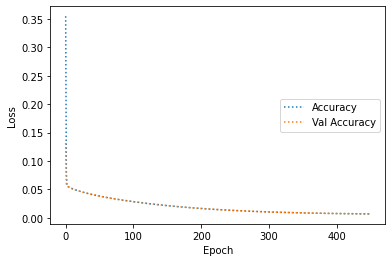

In [8]:
model = models.Sequential()
model.add(layers.Dense(units=64, activation='relu',input_shape=(window_size, features)))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = model.fit(train, train_label, batch_size=batch_size, epochs=450,
                    shuffle=True, validation_data=(val, val_label), 
                    callbacks=[earlyStop])

plt.plot(history.history['mean_absolute_error'], ':', label='Accuracy')
plt.plot(history.history['val_mean_absolute_error'], ':', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='right')
plt.show()

In [9]:
model.evaluate(test, test_label)[1]

1544/1544 [==============================] - 9s 6ms/step - loss: 1.8257e-04 - mean_absolute_error: 0.0066


0.0066342102363705635

In [11]:
np.std(test_label)

0.009044263132020778